# Convolutional neural network

![CNN representation from https://stanford.edu/~shervine/teaching/cs-230/](https://stanford.edu/~shervine/teaching/cs-230/illustrations/architecture-cnn-en.jpeg?3b7fccd728e29dc619e1bd8022bf71cf)

For our example, we will use the [chest X-ray data-set](https://drive.google.com/file/d/1Y9iTkRrfh_2UfoG9o8CRjZc_3rj73nap/view)
from [Kermany et al. 2018](https://www.sciencedirect.com/science/article/pii/S0092867418301545?via%3Dihub)

| normal | pneumonia |
| --- | --- |
| <img alt='a sample normal chest x-ray from Kermany et al. 2018' src='https://github.com/sib-swiss/pytorch-practical-training/blob/master/images/NORMAL-1003233-0001.jpeg?raw=1' width="400"> | <img alt='a pneumonia normal chest x-ray from Kermany et al. 2018' src='https://github.com/sib-swiss/pytorch-practical-training/blob/master/images/BACTERIA-1008087-0001.jpeg?raw=1' width="400"> |



If you need a refresher, you can use the excellent [CNN cheatsheet](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks).

In [1]:
## on google colab, you will have to run the following line:
!pip install pytorch-model-summary
!wget https://github.com/Bjarten/early-stopping-pytorch/raw/refs/heads/main/early_stopping_pytorch/early_stopping.py
!mv early_stopping.py pytorchtools.py

--2025-12-02 09:13:28--  https://github.com/Bjarten/early-stopping-pytorch/raw/refs/heads/main/early_stopping_pytorch/early_stopping.py
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Bjarten/early-stopping-pytorch/refs/heads/main/early_stopping_pytorch/early_stopping.py [following]
--2025-12-02 09:13:28--  https://raw.githubusercontent.com/Bjarten/early-stopping-pytorch/refs/heads/main/early_stopping_pytorch/early_stopping.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2416 (2.4K) [text/plain]
Saving to: ‘early_stopping.py’

early_stopping.py   100%[===================>]   2.36K  --.-KB

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import pytorch_model_summary as pms

from torch.utils.data import TensorDataset, DataLoader

from torchvision.transforms import v2
import torchvision

from pytorchtools import EarlyStopping

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")




Using cpu device


## data pre-processing

The dataset contains
 * 1584 normal x-rays (1349 in train, 234 in validation)
 * 4274 pneumonia x-rays (3883 in train, 390 in validation)

The original data-set is around 1.2GB in size

In [3]:
## on google colab, you will have to run the following lines:

## downloading 2 images:
!mkdir images
!wget https://github.com/sib-swiss/pytorch-practical-training/raw/refs/heads/master/images/NORMAL-1003233-0001.jpeg -O images/NORMAL-1003233-0001.jpeg
!wget https://github.com/sib-swiss/pytorch-practical-training/raw/refs/heads/master/images/BACTERIA-1008087-0001.jpeg -O images/BACTERIA-1008087-0001.jpeg

## downloading an unzipping the full datasets (resized)
!wget https://sibcloud-my.sharepoint.com/:u:/g/personal/wandrille_duchemin_sib_swiss/ESDXFrlw6JJGiK8X7xG4aVEB06cxW82KyK_KWXMwccIVhw?download=1 -O chest_xray_224.zip
!wget https://sibcloud-my.sharepoint.com/:u:/g/personal/wandrille_duchemin_sib_swiss/EZLYtPxO4dlPr-2kysgQFYQBA0iLG3fEWnwrnlwvoHbZwg?download=1 -O chest_xray_64.zip

!mkdir data
!unzip chest_xray_224.zip
!mv chest_xray_224 data

!unzip chest_xray_64.zip
!mv chest_xray_64 data


Streaming output truncated to the last 5000 lines.
 extracting: chest_xray_64/train/NORMAL/NORMAL_591.jpeg  
 extracting: chest_xray_64/train/NORMAL/NORMAL_377.jpeg  
 extracting: chest_xray_64/train/NORMAL/NORMAL_858.jpeg  
 extracting: chest_xray_64/train/NORMAL/NORMAL_1053.jpeg  
 extracting: chest_xray_64/train/NORMAL/NORMAL_646.jpeg  
 extracting: chest_xray_64/train/NORMAL/NORMAL_1344.jpeg  
 extracting: chest_xray_64/train/NORMAL/NORMAL_1134.jpeg  
 extracting: chest_xray_64/train/NORMAL/NORMAL_196.jpeg  
 extracting: chest_xray_64/train/NORMAL/NORMAL_903.jpeg  
 extracting: chest_xray_64/train/NORMAL/NORMAL_125.jpeg  
 extracting: chest_xray_64/train/NORMAL/NORMAL_757.jpeg  
 extracting: chest_xray_64/train/NORMAL/NORMAL_310.jpeg  
 extracting: chest_xray_64/train/NORMAL/NORMAL_194.jpeg  
 extracting: chest_xray_64/train/NORMAL/NORMAL_1204.jpeg  
 extracting: chest_xray_64/train/NORMAL/NORMAL_683.jpeg  
 extracting: chest_xray_64/train/NORMAL/NORMAL_466.jpeg  
 extracting: ches

In [4]:
from torchvision.io import read_image

imgN = read_image( "images/NORMAL-1003233-0001.jpeg" )
imgP = read_image( "images/BACTERIA-1008087-0001.jpeg" )

imgN.shape , imgP.shape

(torch.Size([1, 2476, 2572]), torch.Size([1, 1032, 1152]))

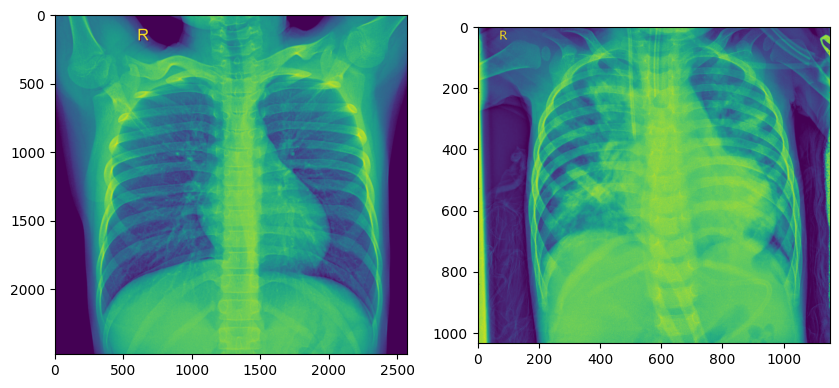

In [5]:
fig,ax = plt.subplots(1,2 , figsize = (10,5))
ax[0].imshow(imgN.numpy()[0])
ax[1].imshow(imgP.numpy()[0])

As they are, each image has its own size, and width to height ratio, so we will need to resize them to a common size first.

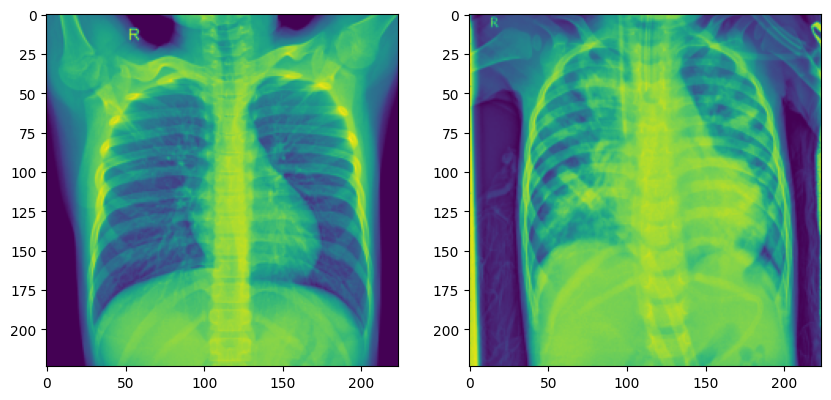

In [6]:
### We use the transformers from torchvision.v2
R = v2.Resize( size = (224,224) , antialias = True )
fig,ax = plt.subplots(1,2 , figsize = (10,5))
ax[0].imshow(R(imgN).numpy()[0])
ax[1].imshow(R(imgP).numpy()[0])

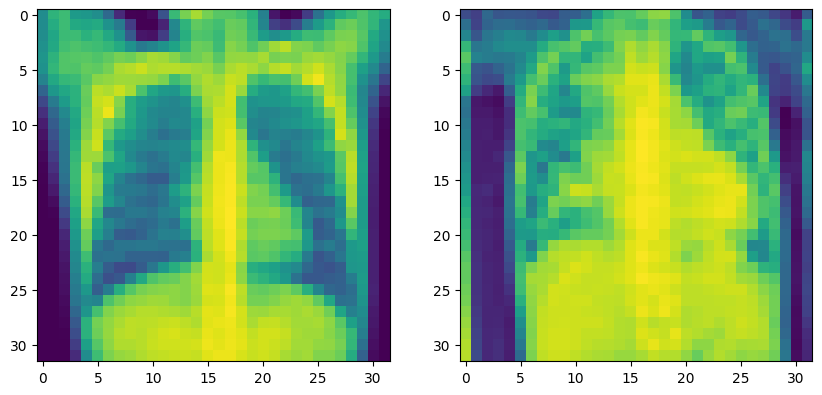

In [7]:
R = v2.Resize( size = (32,32) , antialias = True )
fig,ax = plt.subplots(1,2 , figsize = (10,5))
ax[0].imshow(R(imgN).numpy()[0])
ax[1].imshow(R(imgP).numpy()[0])

How much should we resize?

Should we do other operations?

In image-based applications, it is common to augment a data-set by randomly cropping, rotating, and flipping the  images or shifting their colors or contrast for example.

This is done to make the model resilient to such changes (a picture of a cat should still be classified as a cat, even if the cat is upside-down and in a dark room).


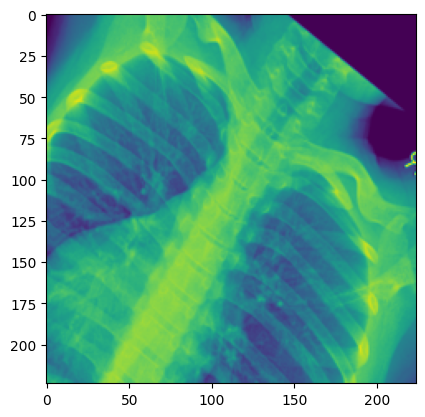

In [8]:
### The classical stuff for classification : flip, crop, resize rotate
## see : https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_getting_started.html#sphx-glr-auto-examples-transforms-plot-transforms-getting-started-py
## for more details

from torchvision.transforms import v2
transforms = v2.Compose([
    v2.RandomRotation(45),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485], std=[0.229]),
])
out = transforms(imgN)

plt.imshow( out.numpy()[0] )

In our case, all our images are fairly well framed x-ray shots and we expect that new images would be similarly well-behaved, so we are only going to apply a resizing and a transformation of the pixel values to floats.

---

For the resize, we will go with a 224x224 size, which is a drastic diminution but still enough to get a fairly good classifier (it will become clear why exactly these values in the next notebook).


The image dataset in organized in several folder: one per target category (here NORMAL and PNEUMONIA).

This is a fairly typical way to organize things, so torchvision already has utilities to load this data

In [ ]:
##
## Here in order to keep the github repo somewhat light we have not included the full resolution images in it
##  but we still keep this time code to in order to showcase how it would behave:
##
%%time
train = torchvision.datasets.ImageFolder("data/chest_xray/train/" ,
                                          loader = read_image)

sizes = []
for x,y in train:
     sizes.extend(x.shape[1:])
print('minimum size:', min(sizes))
print('maximum size:', max(sizes))

Just reading the dataset took ~33.6 s

It becomes even worse when you add the resize transformation:

In [9]:
# %%time
# R = v2.Resize( size = (224,224) , antialias = True )
# train = torchvision.datasets.ImageFolder("data/chest_xray/train/" ,
#                                          loader = read_image,
#                                         transform = R)
# sizes = []
# for x,y in train:
#     sizes.extend(x.shape[1:])
# print('minimum size:', min(sizes))
# print('maximum size:', max(sizes))

You have to think that this would be done at each epoch, so it is not ideal for our performance.

When the dataset is not too large, you could keep all the images in RAM as Tensors and forego this.

Here, because we do not want to do any other transform that a simple resize, we have kept the resized images and use this as dataset (this serves the additional purpose of having the data in the github repo while keeping it light).

In [ ]:
# %%time
##
## code to read the full res-images, transform them and write the result to disk
# import os
# from PIL import Image
# R = v2.Resize( size = (224,224) , antialias = True )
# train = torchvision.datasets.ImageFolder("data/chest_xray/train/" ,
#                                          loader = read_image,
#                                         transform = R)

# baseFolder = 'data/chest_xray_224/train/'

# targets = ["NORMAL",'PNEUMONIA']
# for t in targets:
#     os.makedirs( baseFolder + t )
# for i , XY in enumerate( train ) :
#     x,y = XY

#     folder = baseFolder + targets[y]
#     im = Image.fromarray(x.numpy()[0])
#     im.save( folder + '/' + targets[y] + '_' + str(i) + ".jpeg" )


In [ ]:
# %%time
# import os
# from PIL import Image
# R = v2.Resize( size = (224,224) , antialias = True )
# train = torchvision.datasets.ImageFolder("data/chest_xray/test/" ,
#                                          loader = read_image,
#                                         transform = R)

# baseFolder = 'data/chest_xray_224/test/'

# targets = ["NORMAL",'PNEUMONIA']
# for t in targets:
#     os.makedirs( baseFolder + t )
# for i , XY in enumerate( train ) :
#     x,y = XY

#     folder = baseFolder + targets[y]
#     im = Image.fromarray(x.numpy()[0])
#     im.save( folder + '/' + targets[y] + '_' + str(i) + ".jpeg" )


In [ ]:
%%time
tmp = torchvision.datasets.ImageFolder("data/chest_xray_224/train/" ,
                                         loader = read_image)

sizes = []
for x,y in tmp:
    sizes.extend(x.shape[1:])
print('minimum size:', min(sizes))
print('maximum size:', max(sizes))

much faster

And so, creating our datasets looks like:

In [ ]:
train_dataset = torchvision.datasets.ImageFolder('data/chest_xray_224/train',
                                         loader = read_image,
                                         transform = v2.ToDtype(torch.float32),
                                         target_transform = lambda x : torch.Tensor([x])  )
valid_dataset = torchvision.datasets.ImageFolder('data/chest_xray_224/test',
                                         loader = read_image,
                                         transform = v2.ToDtype(torch.float32),
                                         target_transform = lambda x : torch.Tensor([x])   )


batch_size = 64
train_dataloader = DataLoader( dataset= train_dataset , shuffle=True , batch_size = batch_size )
valid_dataloader = DataLoader( dataset= valid_dataset , shuffle=True , batch_size = batch_size )


**Question:** why do we use `shuffle = True` here ?

## model

first the classical definitions:

In [ ]:
def train(dataloader, model, loss_fn, optimizer ,  echo = True , echo_batch = False):

    size = len(dataloader.dataset) # how many batches do we have
    model.train() #     Sets the module in training mode.

    for batch, (X,y) in enumerate(dataloader): # for each batch
        X = X.to(device) # send the data to the GPU or whatever device you use for training
        y = y.to(device) # send the data to the GPU or whatever device you use for training

        # Compute prediction error
        pred = model(X)              # prediction for the model -> forward pass
        loss = loss_fn(pred, y)      # loss function from these prediction

        # Backpropagation
        loss.backward()              # backward propagation
        #                            https://ml-cheatsheet.readthedocs.io/en/latest/backpropagation.html
        #                            https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html

        optimizer.step()
        optimizer.zero_grad()        # reset the gradients
                                     # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch

        if echo_batch:
            current =  (batch) * dataloader.batch_size +  len(X)
            print(f"Train loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")

    if echo:
        print(f"Train loss: {loss.item():>7f}")

    # return the last batch loss
    return loss.item()


In [ ]:
def valid(dataloader, model, loss_fn, echo = True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() #     Sets the module in evaluation mode
    valid_loss = 0
    with torch.no_grad(): ## disables tracking of gradient: prevent accidental training + speeds up computation
        for X,y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            valid_loss += loss_fn(pred, y).item()  ## accumulating the loss function over the batches

    valid_loss /= num_batches

    if echo:
        print(f"Valid Error: {valid_loss:>8f}")
    ## return the average loss / batch
    return valid_loss


---

Our model will chain a convolutional element with a more classical classifier.



In [ ]:

class CNN(nn.Module):
    def __init__(self, input_size = 224,
                       channel_numbers=1 ,
                       kernel_size= 16,
                       stride = 4):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels = channel_numbers ,
                      out_channels = 2,
                      kernel_size = kernel_size,
                      stride= stride ),
            nn.ReLU(True), # inplace ReLU
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels = 2, out_channels = 4, kernel_size=5, stride=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.flatten = nn.Flatten()

        ###
        flatten_output_dim = 10 ## FIND THIS VALUE
        ###

        self.classifier = nn.Sequential(
            nn.Linear(flatten_output_dim, 16),
            nn.Linear(16, 8),
            nn.Linear(8, 1),
            nn.Sigmoid())

    def forward(self, x):

        out = self.conv(x)

        out = self.flatten(out)

        out = self.classifier(out)

        return out


model = CNN(input_size = 224,
            channel_numbers=1 ,
            kernel_size= 16,
            stride = 4).to(device)
model

**Exercise:** Find the value `flatten_output_dim` : the dimension of the elements getting out of the convolutional layer (after flattening).

If you have the correct size, the following cell will run without issue.

> hint :
> - 2D convolutional layer:
>     - [concept](https://ml-cheatsheet.readthedocs.io/en/latest/layers.html#convolution)
>     - [pytorch doc](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d)
>
> - 2D max pool layer
>     - [concept](https://ml-cheatsheet.readthedocs.io/en/latest/layers.html#pooling)
>     - [pytorch doc](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#maxpool2d)


In [ ]:
torchvision.__version__

In [ ]:
x,y = train_dataset[0]
print(pms.summary(model, x.reshape(1,1,224,224).to(device) , show_input=True))

In [ ]:
# %load solutions/CNN_flatten_output_dim.py

Let's get a batch to check that we can compute our loss

In [ ]:
for batch, (X,y) in enumerate(train_dataloader): # for each batch
    print(batch , X.shape, y.shape)
    break

In [ ]:
loss = nn.BCELoss()

with torch.no_grad():
    pred = model(X.to(device))
    print(pred.shape)
    print( 'avg loss:', loss( pred , y.to(device) ) )

In [ ]:
## we also define this to easily get accuracy
def get_model_accuracy(model, dataloader):
    Ys = np.array([] , dtype = 'float32' )
    Ps = np.array([], dtype = 'float32' )
    with torch.no_grad():
        for X,y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)

            Ys = np.concatenate([Ys, y.squeeze().cpu().numpy()])
            Ps = np.concatenate([Ps, (pred>0.5).squeeze().cpu().numpy()])

    return np.mean( Ys == Ps )

In [ ]:
## preamble -> define the model, the loss function, and the optimizer
model = CNN(input_size = 224,
            channel_numbers=1 ,
            kernel_size= 16,
            stride = 4).to(device)


loss = nn.BCELoss()

#optimizer = torch.optim.SGD(model.parameters(), lr = 5*10**-5 , momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr = 10**-5 )


## container to keep the scores across all epochs
train_scores = []
valid_scores = []


# overfitting can be an issue here.
# we use the early stopping implemented in https://github.com/Bjarten/early-stopping-pytorch
# initialize the early_stopping object.
# patience: How long to wait after last time validation loss improved.
early_stopping = EarlyStopping(patience=25, verbose=False)


In [ ]:
## naive performance
print( "train accuracy:", get_model_accuracy(model, train_dataloader) )
print( "valid accuracy:", get_model_accuracy(model, valid_dataloader) )

In [ ]:
%%time
## lets do a single round, to learn how long it takes
train_scores.append( train(train_dataloader,
                           model,
                           loss,
                           optimizer,
                           echo = True , echo_batch = True ) )

valid_scores.append( valid(valid_dataloader,
                           model,
                           loss ,
                           echo = True) )


In [ ]:
%%time

epoch = 100



for t in range(epoch):
    echo = t%1==0
    if echo:
        print('Epoch',len(train_scores)+1 )

    train_scores.append( train(train_dataloader,
                               model,
                               loss,
                               optimizer,
                               echo = echo , echo_batch = False ) )

    valid_scores.append( valid(valid_dataloader,
                               model,
                               loss ,
                               echo = echo) )

    # early_stopping needs the validation loss to check if it has decresed,
    # and if it has, it will make a checkpoint of the current model
    early_stopping(valid_scores[-1], model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

# load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))


In [ ]:
plt.plot(train_scores , label = 'train')
plt.plot(valid_scores, label = 'validation')
plt.axvline(np.argmin(valid_scores), linestyle='--', color='r',label='Early Stopping Checkpoint')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('BCE loss')

In [ ]:
plt.plot(train_scores , label = 'train')
plt.plot(valid_scores, label = 'validation')
plt.axvline(np.argmin(valid_scores), linestyle='--', color='r',label='Early Stopping Checkpoint')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('BCE loss')

In [ ]:
print( "train accuracy:", get_model_accuracy(model, train_dataloader) )
print( "valid accuracy:", get_model_accuracy(model, valid_dataloader) )


This is not stellar, but it is already fairly nice!

## Exercise:

We have used 224x224 images there.

But maybe for this fairly simple task one could use much smaller images and still get an OK results?

We have created a version of this dataset with 64x64 images, in `data/chest_xray_64/train`.

create adapted dataloaders and adapt the model achitecture.

For example, change the convolutional layer stride and kernel (now there is less pixels, so each pixel counts, so a smaller stride could me more appropriate).

> In our experience, for a model trained for approximately 1 or 2 minutes, you should get performances slightly lower that with the 224x224 images but still respectable

> Note: models I tried have much less parameters and run faster than the one with bigger image, so each epoch was faster and so I let them run for more epoch. I also needed to decrease the learning rate.

In [ ]:
## code to create the 64x64 dataset
##
# %%time
# import os
# from PIL import Image
# S = 64
# R = v2.Resize( size = (S,S) , antialias = True )

# for T in ['train','test']:
#     dataset = torchvision.datasets.ImageFolder("data/chest_xray/"+T+"/" ,
#                                              loader = read_image,
#                                             transform = R)

#     baseFolder = 'data/chest_xray_'+str(S)+'/'+T+'/'

#     targets = ["NORMAL",'PNEUMONIA']
#     for t in targets:
#         os.makedirs( baseFolder + t ,exist_ok=True)
#     for i , XY in enumerate( dataset ) :
#         x,y = XY

#         folder = baseFolder + targets[y]
#         im = Image.fromarray(x.numpy()[0])
#         im.save( folder + '/' + targets[y] + '_' + str(i) + ".jpeg" )


In [ ]:
from torchvision.io import read_image


imgFull    = read_image( "images/BACTERIA-1008087-0001.jpeg" )
imgReduced = read_image( "data/chest_xray_64/train/PNEUMONIA/PNEUMONIA_1349.jpeg" )

fig,ax = plt.subplots(1,2 , figsize = (10,5))
ax[0].imshow(imgFull.numpy()[0])
ax[1].imshow(imgReduced.numpy()[0])

Steps:
 1. create the dataloader
 2. define the model object (you would need to adapt at least the `flatten_output_dim` now that the input image are not the same size)
 3. define the loss function, and the optimizer (SGD with a learning rate of $10^{-5}$ and a momentum of 0.9 should be OK)
 4. do the actual training

Creating the dataloader

In [ ]:
# %load -r 1-14 solutions/CNN_exercise_64.py

Defining the model with a parametric way of getting the `flatten_output_dim`

In [ ]:
# %load -r 15-64 solutions/CNN_exercise_64.py

testing the model

In [ ]:
# %load -r 65-79 solutions/CNN_exercise_64.py

training preamble

In [ ]:
# %load -r 80-106 solutions/CNN_exercise_64.py

Single round

In [ ]:
# %load -r 107-117 solutions/CNN_exercise_64.py

training many epochs

In [ ]:
# %load -r 118-147 solutions/CNN_exercise_64.py

model evaluation

In [ ]:
# %load -r 148- solutions/CNN_exercise_64.py